In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [3]:
import MDAnalysis as mda
import prolif as plf
import numpy as np
import pandas as pd
from rdkit import DataStructs
import glob
from tqdm import tqdm
import os
import seaborn as sns
import datamol as dm
import rdkit
import matplotlib.pyplot as plt
import torch
import warnings
from rdkit.Chem import AllChem
from copy import deepcopy
import rdkit.Chem as Chem

from src.data.datasets import *
from src.utils.prolif import (
    merge_interaction_dfs,
    generate_interaction_df,
    calculate_interaction_similarity,
)

## Main

In [4]:
# calculate cdf with numpy


def cdf(data, lower=None, upper=None):
    """Calculate the CDF of a dataset."""
    # Number of data points: n
    n = len(data)

    data = np.array(data)
    # clip
    if lower is not None:
        data = data.clip(min=lower)
    if upper is not None:
        data = data.clip(max=upper)

    # x-data for the CDF: x
    x = np.sort(data)

    # y-data for the CDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [5]:
# load datasets
crossdocked_generated = DockedMolsDataset("crossdocked_test", docked=False)
crossdocked_docked = DockedMolsDataset("crossdocked_test", docked=True)

diffsbdd_generated = DiffSBDDSamples(docked=False)
diffsbdd_docked = DiffSBDDSamples(docked=True)

targetdiff_generated = DockedMolsDataset("targetdiff", docked=False)
targetdiff_docked = DockedMolsDataset("targetdiff", docked=True)

p2m_generated = DockedMolsDataset("pocket2mol", docked=False)
p2m_docked = DockedMolsDataset("pocket2mol", docked=True)

sbdd_generated = DockedMolsDataset("ar", docked=False)
sbdd_docked = DockedMolsDataset("ar", docked=True)

cvae_generated = DockedMolsDataset("cvae", docked=False)
cvae_docked = DockedMolsDataset("cvae", docked=True)

flag_generated = RedockedData("flag", "score_only")
flag_docked = RedockedData("flag", "redocked")

decompdiff_generated = RedockedData("decompdiff", "score_only")
decompdiff_docked = RedockedData("decompdiff", "redocked")

In [6]:
crossdocked_generated_energies = crossdocked_generated.all_strain_energy
diffsbdd_generated_energies = diffsbdd_generated.all_strain_energy
targetdiff_generated_energies = targetdiff_generated.all_strain_energy
p2m_generated_energies = p2m_generated.all_strain_energy
sbdd_generated_energies = sbdd_generated.all_strain_energy
cvae_generated_energies = cvae_generated.all_strain_energy

flag_generated_energies = flag_generated.all_strain_energy
decompdiff_generated_energies = decompdiff_generated.all_strain_energy

In [7]:
crossdocked_docked_energies = crossdocked_docked.all_strain_energy
diffsbdd_docked_energies = diffsbdd_docked.all_strain_energy
targetdiff_docked_energies = targetdiff_docked.all_strain_energy
p2m_docked_energies = p2m_docked.all_strain_energy
sbdd_docked_energies = sbdd_docked.all_strain_energy
cvae_docked_energies = cvae_docked.all_strain_energy


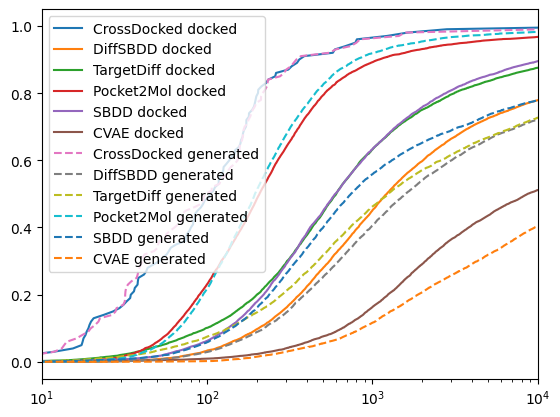

In [8]:
plt.plot(*cdf(crossdocked_docked_energies), label="CrossDocked docked")
plt.plot(*cdf(diffsbdd_docked_energies), label="DiffSBDD docked")
plt.plot(*cdf(targetdiff_docked_energies), label="TargetDiff docked")
plt.plot(*cdf(p2m_docked_energies), label="Pocket2Mol docked")
plt.plot(*cdf(sbdd_docked_energies), label="SBDD docked")
plt.plot(*cdf(cvae_docked_energies), label="CVAE docked")

plt.plot(
    *cdf(crossdocked_generated_energies), label="CrossDocked generated", linestyle="--"
)
plt.plot(*cdf(diffsbdd_generated_energies), label="DiffSBDD generated", linestyle="--")
plt.plot(
    *cdf(targetdiff_generated_energies), label="TargetDiff generated", linestyle="--"
)
plt.plot(*cdf(p2m_generated_energies), label="Pocket2Mol generated", linestyle="--")
plt.plot(*cdf(sbdd_generated_energies), label="SBDD generated", linestyle="--")
plt.plot(*cdf(cvae_generated_energies), label="CVAE generated", linestyle="--")


plt.xscale("log")
plt.xlim(10, 1e4)
plt.legend()

#### Plots

In [9]:
# combine into dataframe
df_crossdocked_generated = pd.DataFrame(
    crossdocked_generated_energies, columns=["Strain Energy"]
)
df_crossdocked_generated["Dataset"] = "CrossDocked"
df_crossdocked_generated["Generated"] = True

df_diffsbdd_generated = pd.DataFrame(
    diffsbdd_generated_energies, columns=["Strain Energy"]
)
df_diffsbdd_generated["Dataset"] = "DiffSBDD"
df_diffsbdd_generated["Generated"] = True

df_targetdiff_generated = pd.DataFrame(
    targetdiff_generated_energies, columns=["Strain Energy"]
)
df_targetdiff_generated["Dataset"] = "TargetDiff"
df_targetdiff_generated["Generated"] = True

df_p2m_generated = pd.DataFrame(p2m_generated_energies, columns=["Strain Energy"])
df_p2m_generated["Dataset"] = "Pocket2Mol"
df_p2m_generated["Generated"] = True

df_sbdd_generated = pd.DataFrame(sbdd_generated_energies, columns=["Strain Energy"])
df_sbdd_generated["Dataset"] = "SBDD"
df_sbdd_generated["Generated"] = True

df_cvae_generated = pd.DataFrame(cvae_generated_energies, columns=["Strain Energy"])
df_cvae_generated["Dataset"] = "LiGAN"
df_cvae_generated["Generated"] = True

df = pd.concat(
    [
        df_crossdocked_generated,
        df_diffsbdd_generated,
        df_targetdiff_generated,
        df_p2m_generated,
        df_sbdd_generated,
        df_cvae_generated,
    ]
)

# climp the energies t0 10,000 and remove NaNs
df["Strain Energy"] = df["Strain Energy"].clip(upper=100000)
df = df.dropna()

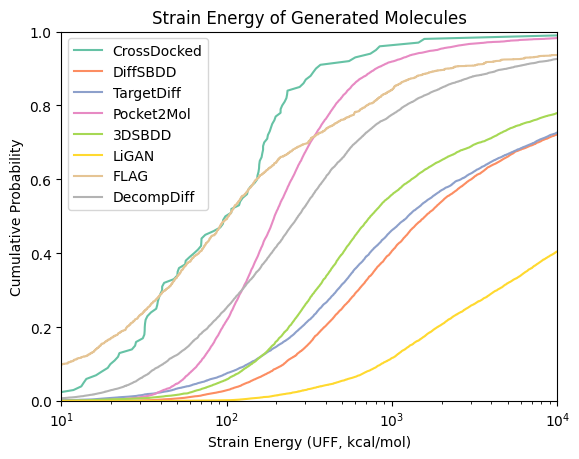

In [11]:
upper = 10**8
lower = -1000

# set pallete
sns.set_palette("Set2")

plt.plot(
    *cdf(crossdocked_generated_energies, lower=lower, upper=upper), label="CrossDocked"
)
plt.plot(*cdf(diffsbdd_generated_energies, lower=lower, upper=upper), label="DiffSBDD")
plt.plot(
    *cdf(targetdiff_generated_energies, lower=lower, upper=upper), label="TargetDiff"
)
plt.plot(*cdf(p2m_generated_energies, lower=lower, upper=upper), label="Pocket2Mol")
plt.plot(*cdf(sbdd_generated_energies, lower=lower, upper=upper), label="3DSBDD")
plt.plot(*cdf(cvae_generated_energies, lower=lower, upper=upper), label="LiGAN")

plt.plot(*cdf(flag_generated_energies, lower=lower, upper=upper), label="FLAG")
plt.plot(*cdf(decompdiff_generated_energies, lower=lower, upper=upper), label="DecompDiff")

plt.legend()

plt.xscale("log")
plt.xlim(10**1, 10**4)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.xlabel("Strain Energy (UFF, kcal/mol)")
plt.title("Strain Energy of Generated Molecules")

plt.savefig("figures/strain_energy_generated.pdf", bbox_inches="tight")

In [11]:
df.groupby("Dataset").describe()

Strain Energy                                                \
                    count          mean           std     min       25%   
Dataset                                                                   
CrossDocked         100.0    469.312800   2199.795468    7.19    37.915   
DiffSBDD           9041.0  13490.338986  28960.830007    7.12   443.450   
LiGAN              9578.0  42231.999440  43027.754907    4.45  2635.245   
Pocket2Mol         9831.0   1131.656748   7022.255953  -30.25   109.135   
SBDD               8270.0   8246.398782  23041.822404 -263.71   259.770   
TargetDiff         9017.0  21150.086651  37178.198392 -233.30   364.140   

                                               
                   50%         75%        max  
Dataset                                        
CrossDocked    102.505     190.140   19270.27  
DiffSBDD      1243.100    5823.370  100000.00  
LiGAN        18693.835  100000.000  100000.00  
Pocket2Mol     194.910     377.855  100000.00  
SBDD           592.225    2342.365  100000.00  
TargetDiff    1241.670   14260.380  100000.00

In [37]:
mols = crossdocked_generated.load_mols(0)

In [71]:
mols = diffsbdd_generated.load_mols(0)

/Users/charlie/opt/anaconda3/envs/poses/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[12:32:04] Explicit valence for atom # 6 O, 3, is greater than permitted
[12:32:04] Explicit valence for atom # 22 O, 3, is greater than permitted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is =)

[12:32:04] Explicit valence for atom # 18 O, 3, is greater than permitted
[12:32:04] Explicit valence for atom # 8 C, 5, is greater than permitted
[12:32:04] Explicit valence for atom # 28 F,

In [ ]:
from rdkit.Chem import rdMolTransforms as rdmt

mol = mols[0]

UFF = AllChem.UFFGetMoleculeForceField(mol)
for bond in mol.GetBonds():
    idx1 = bond.GetBeginAtomIdx()
    idx2 = bond.GetEndAtomIdx()

    stretch_params = rdkit.Chem.rdForceFieldHelpers.GetUFFBondStretchParams(
        mol, idx1, idx2
    )

    print(stretch_params)

    # get the bond length
    bond_length = rdmt.GetBondLength(mol.GetConformer(), idx1, idx2)
    print(bond_length)

In [39]:
def calculate_stretch_terms(mol):
    """Calculate the stretch terms for a molecule."""
    UFF = AllChem.UFFGetMoleculeForceField(mol)
    stretch_terms = []
    for bond in mol.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()

        stretch_params = rdkit.Chem.rdForceFieldHelpers.GetUFFBondStretchParams(
            mol, idx1, idx2
        )

        # get the bond length
        bond_length = rdmt.GetBondLength(mol.GetConformer(), idx1, idx2)

        # calculate the energy
        energy = AllChem.UFFGetBondStretchEnergy(bond_length, *stretch_params)

        stretch_terms.append(energy)

    return stretch_terms


calculate_stretch_terms(mol)

[12:22:11] Molecule does not have explicit Hs. Consider calling AddHs()


AttributeError: module 'rdkit.Chem.AllChem' has no attribute 'UFFGetBondStretchEnergy'

In [7]:
from rdkit import Chem
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem import ChemicalForceFields


def energyTermBreakdown(m):
    try:
        m = Chem.AddHs(m, addCoords=True)
        mp = ChemicalForceFields.MMFFGetMoleculeProperties(m)
        eTotal = 0.0
        ffTerms = ("Bond", "Angle", "StretchBend", "Torsion", "Oop", "VdW", "Ele")

        results = {}

        for iTerm in ffTerms:
            for jTerm in ffTerms:
                state = iTerm == jTerm
                setMethod = getattr(mp, "SetMMFF" + jTerm + "Term")
                setMethod(state)
                ff = rdForceFieldHelpers.MMFFGetMoleculeForceField(m, mp)
                e = ff.CalcEnergy()
                results[iTerm] = e
                eTotal += e
        results["Total"] = eTotal
    except Exception as e:
        print(e)
        results = {
            "Bond": np.nan,
            "Angle": np.nan,
            "StretchBend": np.nan,
            "Torsion": np.nan,
            "Oop": np.nan,
            "VdW": np.nan,
            "Ele": np.nan,
            "Total": np.nan,
        }

    return results


# same as above but with UFF
def energyTermBreakdown(m):
    try:
        m = Chem.AddHs(m, addCoords=True)
        mp = ChemicalForceFields.UFFGetMoleculeProperties(m)
        eTotal = 0.0
        ffTerms = ("Bond", "Angle", "StretchBend", "Torsion", "Oop", "VdW", "Ele")

        results = {}

        for iTerm in ffTerms:
            for jTerm in ffTerms:
                state = iTerm == jTerm
                setMethod = getattr(mp, "SetUFF" + jTerm + "Term")
                setMethod(state)
                ff = rdForceFieldHelpers.UFFGetMoleculeForceField(m, mp)
                e = ff.CalcEnergy()
                results[iTerm] = e
                eTotal += e
        results["Total"] = eTotal
    except Exception as e:
        print(e)
        results = {
            "Bond": np.nan,
            "Angle": np.nan,
            "StretchBend": np.nan,
            "Torsion": np.nan,
            "Oop": np.nan,
            "VdW": np.nan,
            "Ele": np.nan,
            "Total": np.nan,
        }

    return results


energyTermBreakdown(mol)

NameError: name 'mol' is not defined

In [117]:
diffsbdd_terms = [energyTermBreakdown(mol) for mol in mols]

crossdocked_terms = [
    energyTermBreakdown(crossdocked_generated.load_mols(i)[0])
    for i in range(len(crossdocked_generated))
]

targetdiff_terms = [
    energyTermBreakdown(targetdiff_generated.load_mols(i)[0])
    for i in range(len(targetdiff_generated))
]
p2m_terms = [
    energyTermBreakdown(p2m_generated.load_mols(i)[0])
    for i in range(len(p2m_generated))
]
# sbdd_terms = [energyTermBreakdown(sbdd_generated.load_mols(i)[0]) for i in range(len(sbdd_generated))]
cvae_terms = [
    energyTermBreakdown(cvae_generated.load_mols(i)[0])
    for i in range(len(cvae_generated))
]

'NoneType' object has no attribute 'SetMMFFBondTerm'
'NoneType' object has no attribute 'SetMMFFBondTerm'
'NoneType' object has no attribute 'SetMMFFBondTerm'
'NoneType' object has no attribute 'SetMMFFBondTerm'
'NoneType' object has no attribute 'SetMMFFBondTerm'
'NoneType' object has no attribute 'SetMMFFBondTerm'
'NoneType' object has no attribute 'SetMMFFBondTerm'


In [118]:
diffsbdd_df = pd.DataFrame(diffsbdd_terms)
crossdocked_df = pd.DataFrame(crossdocked_terms)
targetdiff_df = pd.DataFrame(targetdiff_terms)
p2m_df = pd.DataFrame(p2m_terms)
# sbdd_df = pd.DataFrame(sbdd_terms)
cvae_df = pd.DataFrame(cvae_terms)

diffsbdd_df["Dataset"] = "DiffSBDD"
crossdocked_df["Dataset"] = "CrossDocked"
targetdiff_df["Dataset"] = "TargetDiff"
p2m_df["Dataset"] = "Pocket2Mol"
# sbdd_df['Dataset'] = 'SBDD'
cvae_df["Dataset"] = "LiGAN"

df = pd.concat([diffsbdd_df, crossdocked_df, targetdiff_df, p2m_df, cvae_df])

# melt the dataframe
df = df.melt(id_vars=["Dataset"], var_name="Term", value_name="Energy")
df

,Dataset,Term,Energy
0,DiffSBDD,Bond,297.835396
1,DiffSBDD,Bond,41.190304
2,DiffSBDD,Bond,56.621314
3,DiffSBDD,Bond,45.917006
4,DiffSBDD,Bond,69.077453
...,...,...,...
3995,LiGAN,Total,36284.379061
3996,LiGAN,Total,1712.760677
3997,LiGAN,Total,37572.406632
3998,LiGAN,Total,54633.984843


(-100.0, 1000.0)

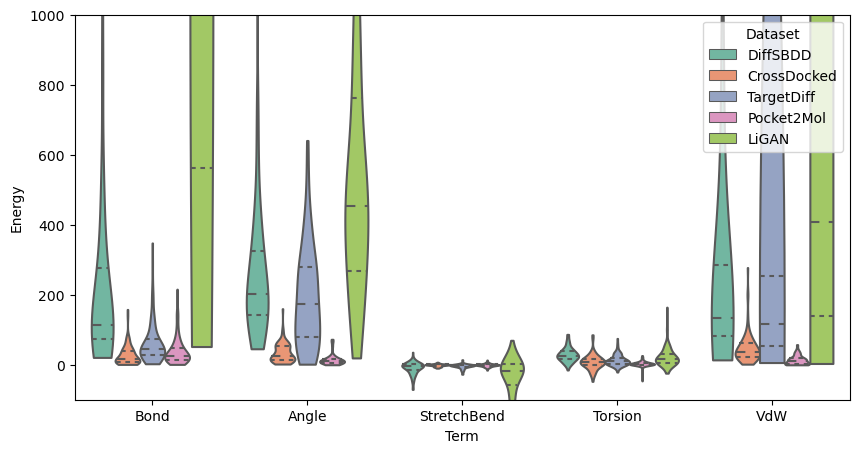

In [124]:
# set fig size
plt.figure(figsize=(10, 5))

# remove total, ele, opp
new_df = df[~df["Term"].isin(["Total", "Ele", "Oop"])]

sns.violinplot(
    data=new_df,
    x="Term",
    y="Energy",
    hue="Dataset",
    inner="quartile",
    scale="count",
    cut=0,
)

# plt.yscale('log')
plt.ylim(-100, 1000)

In [141]:
for dataset in stats.index.levels[2]:
    print(dataset)

IndexError: list index out of range

In [155]:
stats

Energy                            
                                 mean            std          50%
Dataset     Term                                                 
CrossDocked Angle           34.175862      26.592764    25.063285
            Bond            27.207425      27.266269    17.590463
            StretchBend     -1.181926       3.521484    -0.173829
            Torsion          7.980138      21.314354     6.635060
            VdW             47.026495      41.445146    37.424303
DiffSBDD    Angle          260.713535     220.786332   201.519011
            Bond           224.951131     280.848511   113.333127
            StretchBend     -9.324670      17.517544    -4.690561
            Torsion         28.807040      19.895410    25.978093
            VdW            340.149315     550.735348   133.049824
LiGAN       Angle          534.845437     362.628955   454.509001
            Bond          2809.969245    4211.945167  1354.887386
            StretchBend    -35.588541      61.720304   -17.402216
            Torsion         22.975801      29.079205    16.322242
            VdW          16010.683133  111216.152193   407.530756
Pocket2Mol  Angle           14.776615      16.072289    10.270408
            Bond            38.977800      37.694676    25.914938
            StretchBend     -1.182165       4.412653    -0.749411
            Torsion          3.281813       7.478800     2.047674
            VdW             13.178710      13.336053    10.921010
TargetDiff  Angle          192.441898     144.522026   173.139042
            Bond            61.597294      59.109809    45.189268
            StretchBend     -4.019791       6.928795    -2.075121
            Torsion         12.907003      15.677442     9.700146
            VdW            863.767593    2434.429421   115.604389

In [174]:
# remove total, ele, opp
new_df = df[~df["Term"].isin(["Total", "Ele", "Oop"])]

# dont show countm min and max
stats = new_df.groupby(["Dataset", "Term"]).describe()
stats
# remove count min and max, 25% and 75%
stats = stats.drop(
    columns=[
        ("Energy", "count"),
        ("Energy", "min"),
        ("Energy", "max"),
        ("Energy", "25%"),
        ("Energy", "75%"),
    ]
)

# refactor the index
# stats = stats.reset_index(level=[0, 1])
# terms alone the x axis
stats = stats.unstack(level=1)
# nest the columns
stats = stats.stack(level=[1])
# put median and mean in the same column
stats = stats.unstack(level=1)
stats


# print as single latex table for paper with std and mean in single cell
print(
    stats.to_latex(float_format="%.2f", multirow=True, multicolumn=True, bold_rows=True)
)

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{15}{l}{Energy} \\
\textbf{Term} & \multicolumn{3}{l}{Angle} & \multicolumn{3}{l}{Bond} & \multicolumn{3}{l}{StretchBend} & \multicolumn{3}{l}{Torsion} & \multicolumn{3}{l}{VdW} \\
{} &    50\% &   mean &    std &     50\% &    mean &     std &         50\% &   mean &   std &     50\% &  mean &   std &    50\% &     mean &       std \\
\textbf{Dataset    } &        &        &        &         &         &         &             &        &       &         &       &       &        &          &           \\
\midrule
\textbf{CrossDocked} &  25.06 &  34.18 &  26.59 &   17.59 &   27.21 &   27.27 &       -0.17 &  -1.18 &  3.52 &    6.64 &  7.98 & 21.31 &  37.42 &    47.03 &     41.45 \\
\textbf{DiffSBDD   } & 201.52 & 260.71 & 220.79 &  113.33 &  224.95 &  280.85 &       -4.69 &  -9.32 & 17.52 &   25.98 & 28.81 & 19.90 & 133.05 &   340.15 &    550.74 \\
\textbf{LiGAN      } & 454.51 & 534.85 & 362.63 & 1354.89 & 2809.97 & 4211.95 &    

/var/folders/38/9bdhd5_93c3bfmchy1pn4yj80000gn/T/ipykernel_38565/1592515625.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(float_format="%.2f", multirow=True, multicolumn=True, bold_rows=True))


: 

In [ ]:
\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{15}{l}{Energy} \\
\textbf{Term} & \multicolumn{3}{l}{Angle} & \multicolumn{3}{l}{Bond} & \multicolumn{3}{l}{StretchBend} & \multicolumn{3}{l}{Torsion} & \multicolumn{3}{l}{VdW} \\
{} &    50\% &   mean &    std &     50\% &    mean &     std &         50\% &   mean &   std &     50\% &  mean &   std &    50\% &     mean &       std \\
\textbf{Dataset    } &        &        &        &         &         &         &             &        &       &         &       &       &        &          &           \\
\midrule
\textbf{CrossDocked} &  25.06 &  34.18 &  26.59 &   17.59 &   27.21 &   27.27 &       -0.17 &  -1.18 &  3.52 &    6.64 &  7.98 & 21.31 &  37.42 &    47.03 &     41.45 \\
\textbf{DiffSBDD   } & 201.52 & 260.71 & 220.79 &  113.33 &  224.95 &  280.85 &       -4.69 &  -9.32 & 17.52 &   25.98 & 28.81 & 19.90 & 133.05 &   340.15 &    550.74 \\
\textbf{LiGAN      } & 454.51 & 534.85 & 362.63 & 1354.89 & 2809.97 & 4211.95 &      -17.40 & -35.59 & 61.72 &   16.32 & 22.98 & 29.08 & 407.53 & 16010.68 & 111216.15 \\
\textbf{Pocket2Mol } &  10.27 &  14.78 &  16.07 &   25.91 &   38.98 &   37.69 &       -0.75 &  -1.18 &  4.41 &    2.05 &  3.28 &  7.48 &  10.92 &    13.18 &     13.34 \\
\textbf{TargetDiff } & 173.14 & 192.44 & 144.52 &   45.19 &   61.60 &   59.11 &       -2.08 &  -4.02 &  6.93 &    9.70 & 12.91 & 15.68 & 115.60 &   863.77 &   2434.43 \\
\bottomrule
\end{tabular}

# turn above text


In [52]:
energyTermBreakdown(mols[0])

Bond energy: 297.0410
Angle energy: 217.0544
StretchBend energy: -30.7977
Torsion energy: 39.3404
Oop energy: 1.0440
VdW energy: 43.2801
Ele energy: -58.8784
Total energy: 508.0839


[12:27:33] Molecule does not have explicit Hs. Consider calling AddHs()


In [20]:
UFF.CalcEnergy()

766.3845515118038

In [24]:
dm.add_hs(mol, add_coords=True).GetNumAtoms()

64

In [25]:
len(UFF.CalcGrad())

105

In [30]:
# Calculate individual energy terms
def calculate_energy_terms(mol):
    # add hydrogens
    mol = dm.add_hs(mol, add_coords=True)

    # get forcefield
    UFF = AllChem.UFFGetMoleculeForceField(mol)

    # get energy terms
    bond_energies = []
    angle_energies = []
    torsion_energies = []
    vdw_energies = []
    elec_energies = []

    for bond in mol.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()

        bond_length = rdmt.GetBondLength(mol.GetConformer(), idx1, idx2)

        atom1_type = bond.GetBeginAtom().GetSymbol()
        atom2_type = bond.GetEndAtom().GetSymbol()

        parameters = UFF.GetUFFBondStretchParams(atom1_type, atom2_type)

        bond_length_energy = parameters[2] * (bond_length - parameters[1]) ** 2

        bond_energies.append(bond_length_energy)

    for angle in mol.GetAngles():
        idx1 = angle[0]
        idx2 = angle[1]
        idx3 = angle[2]

        angle = rdmt.GetAngleRad(mol.GetConformer(), idx1, idx2, idx3)

        atom1_type = mol.GetAtomWithIdx(idx1).GetSymbol()
        atom2_type = mol.GetAtomWithIdx(idx2).GetSymbol()
        atom3_type = mol.GetAtomWithIdx(idx3).GetSymbol()

        parameters = UFF.GetUFFAngleBendParams(atom1_type, atom2_type, atom3_type)

        angle_energy = parameters[2] * (angle - parameters[1]) ** 2

        angle_energies.append(angle_energy)

    for torsion in mol.GetConformer().GetTorsionMap():
        idx1 = torsion[0]
        idx2 = torsion[1]
        idx3 = torsion[2]
        idx4 = torsion[3]

        torsion = rdmt.GetDihedralRad(mol.GetConformer(), idx1, idx2, idx3, idx4)

        atom1_type = mol.GetAtomWithIdx(idx1).GetSymbol()
        atom2_type = mol.GetAtomWithIdx(idx2).GetSymbol()
        atom3_type = mol.GetAtomWithIdx(idx3).GetSymbol()

        parameters = UFF.GetUFFTorsionParams(
            atom1_type, atom2_type, atom3_type, atom4_type
        )

        torsion_energy = parameters[3] * (
            1 + np.cos(parameters[2] * torsion - parameters[1])
        )

        torsion_energies.append(torsion_energy)


calculate_energy_terms(mol)

AttributeError: 'ForceField' object has no attribute 'GetUFFBondStretchParams'

In [34]:
rdkit.Chem.rdForceFieldHelpers.GetUFFBondStretchParams(mol, 1, 2)

(739.8878690540488, 1.486)